# Comparison Classification for Few Shot Learning MNIST

The model is given two images and predicts whether they are of the same class or different. It is trained on digits 0, 1, 2, 3, 4, 5 and 6, and tested on 7, 8 and 9. It achieved 60-70% validation accuracy on the unseen numbers task during training, confusion-matrix-like plots are provided at the end with some analysis of its behavior.

Go to the **evaluation** section for results.

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt #for plotting

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, concatenate, Input
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization

/usr/local/miniconda3/envs/testml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/local/miniconda3/envs/testml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/miniconda3/envs/testml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%matplotlib inline

# Data Mangling

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

0


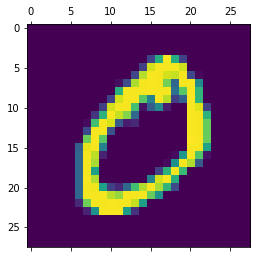

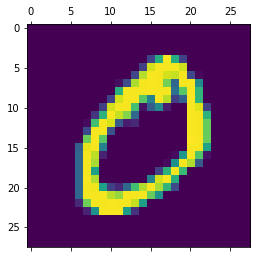

In [4]:
# prepare dataset:
# input is a pair of images, output is 1 if they are the same class, 0 if different class
# also, have about 50/50 of same/not-same so accuracy is easier to understand
# also, training data only has digits 0, 1, 2, 3, 4. Test can either be on those or on new digits.
print(y_train[1])
plt.matshow(x_train[1])
plt.matshow(x_train[1])

In [47]:
def put_in_bins(labels):
    bins = {i:list() for i in range(0, 10)}
    for i, x in enumerate(labels):
        bins[x].append(i)
    return bins
        
put_in_bins(y_train[0:50])

{0: [1, 21, 34, 37],
 1: [3, 6, 8, 14, 23, 24, 40],
 2: [5, 16, 25, 28],
 3: [7, 10, 12, 27, 30, 44, 49],
 4: [2, 9, 20, 26],
 5: [0, 11, 35, 47],
 6: [13, 18, 32, 36, 39],
 7: [15, 29, 38, 42],
 8: [17, 31, 41, 46],
 9: [4, 19, 22, 33, 43, 45, 48]}

In [6]:
def parallel_shuffle(list_of_arrays):
    " shuffles all the arrays (of same length) in the same way"
    length = list_of_arrays[0].shape[0]
    
    # check that all are the same length
    for array in list_of_arrays:
        assert array.shape[0] == length
        
    indices = np.random.permutation(length) # shuffle indices
    output = list()
    for array in list_of_arrays:
        output.append(array[indices])
    return output

parallel_shuffle([np.array([1, 2, 3]), np.array(['a', 'b', 'c'])])

[array([1, 2, 3]), array(['a', 'b', 'c'], dtype='<U1')]

22
vars:  21 14 0
a class:  0
b class:  1
is_same:  0


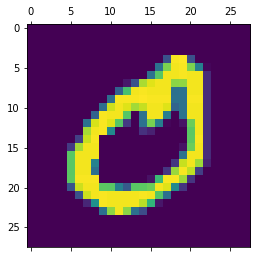

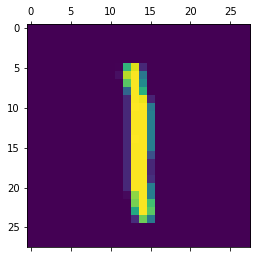

In [248]:
# given array of labels, take each one with a random one in a different class, and a random on in the same class
def build_dataset_indexes(labels, allowed_labels):
    bins = put_in_bins(labels)
    for label in allowed_labels:
        for i in bins[label]:
            yield i, np.random.choice(bins[label]), 1 # indexes of 2 image in same class
            anything_but_label = np.random.choice([x for x in allowed_labels if x != label])
            yield i, np.random.choice(bins[anything_but_label]), 0 # indexes of 2 images in different classes
                
            
foo = list(build_dataset_indexes(y_train[0:50], [0, 1]))
print(len(foo))
a, b, is_same = foo[3]
print("vars: ", a, b, is_same)
plt.matshow(x_train[a])
print("a class: ", y_train[a])

plt.matshow(x_train[b])
print("b class: ", y_train[b])

print("is_same: ", is_same)

In [249]:
# not a good name, but I think of it as popping out the bottom level
def pop_dims(arr):
    " Expands bottom dims, so a (100, 28, 28) array would become (100, 28, 28, 1)"
    return np.expand_dims(arr, axis=-1)
def unpop_dims(arr):
    " removes bottom dim, for viewing ease"
    return np.squeeze(arr, axis=-1)

foo = np.zeros((5, 2, 2))
pop_dims(foo).shape
unpop_dims(pop_dims(foo)).shape

(5, 2, 2)

[1 2]


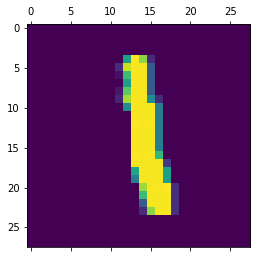

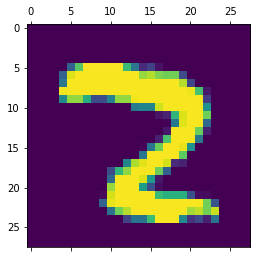

In [261]:
def build_dataset(images, labels, allowed_labels):
    left_images = list()
    right_images = list()
    labels_for_image_pairs = list()
    original_labels = list()
    for a_index, b_index, is_same in build_dataset_indexes(labels, allowed_labels):
        left_images.append(images[a_index])
        right_images.append(images[b_index])
        labels_for_image_pairs.append(is_same)
        original_labels.append([labels[a_index], labels[b_index]])
    return parallel_shuffle([pop_dims(np.array(left_images)), 
            pop_dims(np.array(right_images)), 
            pop_dims(np.array(labels_for_image_pairs)),
            np.array(original_labels)])
        
li, ri, labels, original_labels = build_dataset(x_train[0:50], y_train[0:50], [0, 1, 2])
x = 0
plt.matshow(unpop_dims(li[x]))
plt.matshow(unpop_dims(ri[x]))
print(original_labels[x])
#print(labels[x])

# Model Construction

In [262]:
input_shape = (28, 28, 1)

In [263]:
# compressor creates a lsr of the input image using a simple convnet

# layers from here: https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457
compressor_layers1 = [\
    Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'),
    Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'),
    MaxPool2D((2, 2)),
    Dropout(0.20),
    Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'),
    Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu')]

compressor_layers = [\
    Conv2D(2, kernel_size=(5, 5),activation='relu',kernel_initializer='he_normal'),
    MaxPool2D((2, 2)),
    Conv2D(4, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'),
    MaxPool2D((2, 2)),
    Dropout(0.25),
   # Conv2D(16, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'),
    Flatten(),
    Dense(128, activation='relu')]
def compressor_fun(frame):
        x = frame
        for layer in compressor_layers:
            x = layer(x)
        return x




In [264]:
# is_same_class takes two lsrs and tells if they are the same o
# or different class
lsr_compare_layers = [Dense(16), Activation('relu'), 
        Dense(16), Activation('relu'),
        Dense(16), Activation('linear'), # never have relu before sigmoid! Always positive! Bad!
        Dense(16), Activation('linear'), # never have relu before sigmoid! Always positive! Bad!
        Dense(1, kernel_initializer='normal', activation='sigmoid')]
def lsr_compare(combined_lsr):
        x = combined_lsr
        for layer in lsr_compare_layers:
            x = layer(x)
        return x

In [265]:
 
# compute is_same_class from two input images
left_image_input = Input(shape=(28, 28, 1))
right_image_input = Input(shape=(28, 28, 1))
left_lsr = compressor_fun(left_image_input)
right_lsr = compressor_fun(right_image_input)
combined_lsr = concatenate([left_lsr, right_lsr])
is_same_class = lsr_compare(combined_lsr) # 1 for images are same class, 0 for different class

# define and compile the model
model = Model(inputs=[left_image_input, right_image_input], outputs=is_same_class)
model.compile(optimizer='adam',
              #loss='mse',
              loss='binary_crossentropy', 
                  metrics=['binary_accuracy'])


model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 24, 24, 2)    52          input_47[0][0]                   
                                                                 input_48[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_35 (MaxPooling2D) (None, 12, 12, 2)    0           conv2d_70[0][0]                  
          

# Training

In [266]:
training_labels = [0, 1, 2, 3, 4, 5, 6]
evaluation_labels = [x for x in range(10) if x not in training_labels]

In [267]:
model.reset_states() # so the shown training run is genuine and reproducible

In [268]:
n_samples = 1200 # one tenth the dataset, because no gpu
left_images, right_images, labels, _ = build_dataset(x_train[:n_samples], 
                                                  y_train[:n_samples], 
                                                  training_labels)

# validation data
validation_left_images, validation_right_images, validation_labels, _ =\
    build_dataset(x_test[:500], y_test[:500], evaluation_labels)

model.fit([left_images, right_images], labels, epochs=40, batch_size=200,
         validation_data=([validation_left_images, validation_right_images], validation_labels))

number train:  1666
Train on 1666 samples, validate on 286 samples
Epoch 1/40
1666/1666 [==============================] - 6s 4ms/step - loss: 1.2147 - binary_accuracy: 0.5018 - val_loss: 0.6912 - val_binary_accuracy: 0.5175
Epoch 2/40
1666/1666 [==============================] - 1s 900us/step - loss: 0.7266 - binary_accuracy: 0.4820 - val_loss: 0.6878 - val_binary_accuracy: 0.5594
Epoch 3/40
1666/1666 [==============================] - 1s 811us/step - loss: 0.7005 - binary_accuracy: 0.5132 - val_loss: 0.6942 - val_binary_accuracy: 0.5105
Epoch 4/40
1666/1666 [==============================] - 1s 884us/step - loss: 0.6929 - binary_accuracy: 0.5294 - val_loss: 0.6935 - val_binary_accuracy: 0.5035
Epoch 5/40
1666/1666 [==============================] - 1s 819us/step - loss: 0.6814 - binary_accuracy: 0.5432 - val_loss: 0.6973 - val_binary_accuracy: 0.5210
Epoch 6/40
1666/1666 [==============================] - 1s 839us/step - loss: 0.6714 - binary_accuracy: 0.5606 - val_loss: 0.7036 - val

In [348]:
model.predict([left_images[:10], right_images[:10]]) # check that it isn't constant or something

array([[0.00982082],
       [0.00606236],
       [0.99822634],
       [0.06509727],
       [0.99939144],
       [0.92315745],
       [0.22992286],
       [0.91837054],
       [0.0118261 ],
       [0.9199493 ]], dtype=float32)

# Evaluation 

In [212]:
# check acc with 
loss, acc = model.evaluate([left_images, right_images], labels, batch_size=10)
print("with same data!! as training, acc = ", acc)


1666/1666 [==============================] - 4s 3ms/step
with same data!! as training, acc =  0.9741896708615545


In [272]:
# check accuracy for same labels
left_images, right_images, labels, orignal_labels =\
    build_dataset(x_test[:500], y_test[:500], training_labels)
loss, acc = model.evaluate([left_images, right_images], labels, batch_size=10)
print("with same labels as training, acc = ", acc)

# accuracy for different labels, v_ for "validation"
left_images, right_images, labels, original_labels =\
    build_dataset(x_test[:500], y_test[:500], evaluation_labels)
loss, acc = model.evaluate([left_images, right_images], labels, batch_size=10)
print("with difff labels as training, acc = ", acc)

714/714 [==============================] - 0s 600us/step
with same labels as training, acc =  0.8809523742739894
286/286 [==============================] - 0s 701us/step
with difff labels as training, acc =  0.5909090990369971


# Training Accuray: 97.4%

# Test Accuray: 88.1%

# Different Labels Accuray: 59.1%

The "different labels" task is unusual compared to ordinary ML tasks. The train and test were both only shown digits 0 through 6. The "different labels" task was tested only on the label 7, 8, and 9. 

Another useful task would be where 7, 8, or 9 appear with any possible label, but that can be observed in the confusion matrices.

# "Confusion Matrices"

These are no ordinary confusion matrices. I'm actaully a bit skeptical on how they should be interpreted, but here is my best shot.

In [315]:
# Make a confusion matric, much harder than usual. We'll have to mangle some stuff manually.
left_images, right_images, labels, original_labels =\
    build_dataset(x_test[:500], y_test[:500], list(range(10)))

predictions = model.predict([left_images, right_images])

In [ ]:
# first, build a dict that takes a tuple of (left_label, right_label) and stores a list of 
same_but_predicted_different = np.zeros(shape=(10, 10))
same_and_predicted_same = np.zeros(shape=(10, 10))
different_but_predicted_same = np.zeros(shape=(10, 10))
different_and_predicted_different = np.zeros(shape=(10, 10))

for prediction, label, (left_image_label, right_image_label) in\
        zip(unpop_dims(predictions), unpop_dims(labels), original_labels):
    #print(np.rint(prediction).astype(int), left_image_label, right_image_label, label)
    pred_label = np.rint(prediction).astype(int)
    if label == 1 and pred_label ==  0: 
        same_but_predicted_different[left_image_label][right_image_label] += 1
    if label == 1 and pred_label ==  1: 
        same_and_predicted_same[left_image_label][right_image_label] += 1
    if label == 0 and pred_label ==  1: 
        different_but_predicted_same[left_image_label][right_image_label] += 1
    if label == 0 and pred_label ==  0:
        different_and_predicted_different[left_image_label][right_image_label] += 1

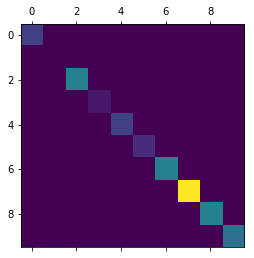

In [339]:
plt.matshow(same_but_predicted_different)

## ^ Same but Predicted Different ^

The network incorrectly predicted the images were in different image classes, when they were really the same.

Notice the hot spot at (7,7), the networks didn't train on 7's and often saw two 7's as not belonging to the same class when they actually were. We'll see lates that it often confuses 7's with 2's.

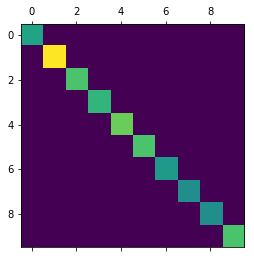

In [340]:
plt.matshow(same_and_predicted_same)

## ^ Same and Predicted Same ^

The network correctly predicted the two images were in the same image class. The last three classes are image classes it has never seen before (7, 8, 9), meaning it could look at two 8's and tell accuratly that they were in the same class, even though it had never seen an 8 before. 

Also the hot spot at (1, 1) indicates it is very good at comparing 1's

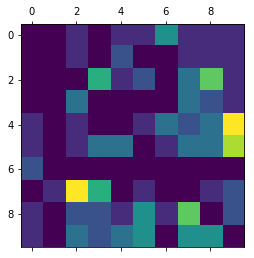

In [341]:
plt.matshow(different_but_predicted_same)

## ^ Different but Predicted Same ^

The network predicted the two images were of the same class, but in fact they were of different classes.

The hot spots are at (7, 2), (4, 9) and (5, 9). This means if it saw any of those pairs of numbers, it would often believe they are they same digit. These are reasonable mistakes to make.

Notice the high quality area in the rectangle from the top left to the (6,6) square. This is comparing known classes with known classes. Outside of this area, mistakes are more frequent.

Also notice that the matrix isn't symmeric across the diagonal. This means that swapping the left and right digit can change what it predicts. This isn't unexpected, and might just be a bias in the data.

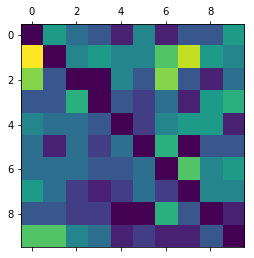

In [342]:
plt.matshow(different_and_predicted_different)

## ^ Different and Predicted Different ^

The network correctly predicted that the two images were not in the same class. It is especially accurate between (1, 0), (1, 7), and (1, 2). This is the inverse of the previous plot, and helps highlight accurate spots visually.

In [343]:
n_correct = same_and_predicted_same + different_and_predicted_different

In [344]:
n_incorrect = same_but_predicted_different + different_but_predicted_same

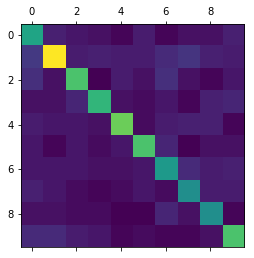

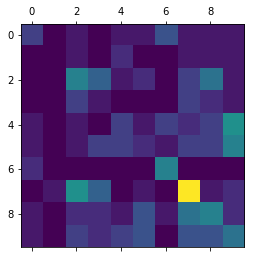

In [349]:
plt.matshow(n_correct)
plt.matshow(n_incorrect)

## Sum of correct prediction matrices and incorrect prediction matrices

Possibly a more useful form from the 4 different ones above.

# Conclusion

The model can correctly classify within never-before-seen digit classes with 60-70% accuracy, and very little tuning has been done. This technique seems valid, and allows for comparison classification within a meta-class. Here the meta-class learned is "handwritten digits", and I would expect an invented digit or even letters would get a somewhat decent accuracy even if it was only trained on digits.